# POLI 175 - Lecture 07

## Regression (final)

## Regression and Classification

Loading packages:

In [1]:
# If needed
using Pkg
Pkg.add("Lowess")
Pkg.add("Gadfly")
Pkg.add("RegressionTables")
Pkg.add("CovarianceMatrices")
Pkg.add("Econometrics")
Pkg.add("LinearAlgebra")
Pkg.add("MixedModelsExtras")
Pkg.update()

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Chan

## Regression and Classification

Loading packages:

In [2]:
## Loading the data
using CSV, DataFrames, Plots, GLM, StatsBase, Random
using LaTeXStrings, StatsPlots, Lowess, Gadfly, RegressionTables
using CovarianceMatrices, Econometrics, LinearAlgebra, MixedModelsExtras

# Auxiliar function
function pairplot(df)
    _, cols = size(df)
    plots = []
    for row = 1:cols, col = 1:cols
        push!(
            plots,
            scatter(
                df[:, row],
                df[:, col],
                xtickfont = font(4),
                ytickfont = font(4),
                legend = false,
            ),
        )
    end
    Plots.plot(plots..., layout = (cols, cols))
end

pairplot (generic function with 1 method)

## Regression and Classification

Loading data:

In [3]:
# URL of the prestige dataset
urldat = "https://raw.githubusercontent.com/umbertomig/POLI175julia/main/data/Duncan.csv"

# Load the CSV file
dat = CSV.read(download(urldat), DataFrame)

# First few obs
first(dat, 3)

3×5 DataFrame
 Row │ type     income  education  prestige  profession 
     │ String7  Int64   Int64      Int64     String31   
─────┼──────────────────────────────────────────────────
   1 │ prof         62         86        82  accountant
   2 │ prof         72         76        83  pilot
   3 │ prof         75         92        90  architect

## Regression

There are many packages in Julia to run Regression and Classification models. We are going to use two:

- [`GLM`](https://github.com/JuliaStats/GLM.jl) and its family (https://juliastats.org/)
- [`MLJ`](https://alan-turing-institute.github.io/MLJ.jl/dev/)

We have been using the [GLM](https://github.com/JuliaStats/GLM.jl). Next lecture we will center on the [MLJ](https://alan-turing-institute.github.io/MLJ.jl/dev/).

## Regression

### Questions

Quick reminder of a few relevant questions on the prestige of professions dataset:

Questions we answered:

- Is there a relationship between `prestige` and `income`?
- How strong is the relationship between `prestige` and `income`?
- Which variables are associated with `prestige`?
- How can we accurately predict the prestige of professions not studied in this survey?

Questions that we are still to answer:

- Is the relationship linear?
- Is there a synergy among predictors?

## Regression

### Simplest Model

In [4]:
mod = lm(@formula(prestige ~ income), dat)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

prestige ~ 1 + income

Coefficients:
───────────────────────────────────────────────────────────────────────
               Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────
(Intercept)  2.45657    5.19006    0.47    0.6384   -8.01018   12.9233
income       1.08039    0.107369  10.06    <1e-12    0.86386    1.29692
───────────────────────────────────────────────────────────────────────

## Diagnostics

Several plots can help us diagnose the quality of our model.

**Warning**: Find and analyzing these violations is **more of an art**.

A careful analysis is frequent enough to ensure you have a `good` model.

## Diagnostics

### Non-linearity

When the relationship is non-linear, you could have done better using a different (more flexible) functional form.

The plot to detect this is residual in the y-axis against the fitted values in the x-axis:

![reg](https://github.com/umbertomig/POLI175julia/blob/c9b0555e3e97778495bee72746aee43ddf3226d7/img/fig5.png?raw=true)

**Plot**: Fitted Values x Raw Residuals

- Good: You should find no patterns.

- Bad: A discernible pattern tells you that you could have done better with a more flexible model.

## Diagnostics

### Non-linearity

But how to find the fitted values and the residuals in the GLM package?

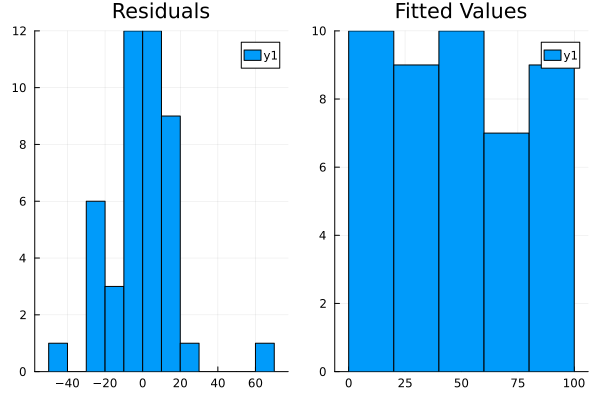

In [5]:
# Residuals
histogram(residuals(mod))
p1 = histogram(residuals(mod))
title!("Residuals")
p2 = histogram(fitted(mod))
title!("Fitted Values")
Plots.plot(p1, p2, layout = (1, 2))

## Diagnostics

### Non-linearity

For the `prestige` x `income` relationship:

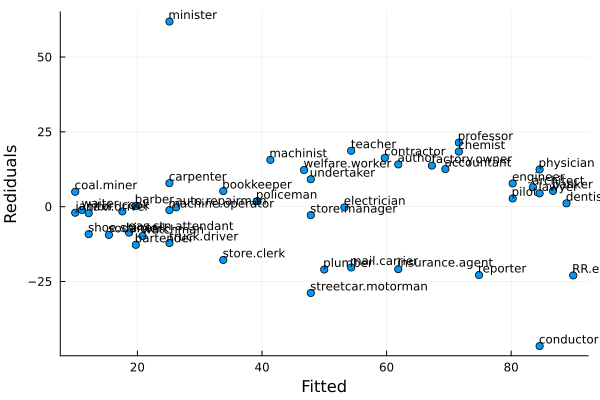

In [6]:
# Residual x fitted values (linearity + heteroscedasticity)
Plots.scatter(
    fitted(mod), residuals(mod),
    xlabel = "Fitted", ylabel = "Rediduals",
    series_annotations = text.(dat.profession, :left, :bottom, 8),
    legend = false
)

## Diagnostics

### Non-linearity

Hint: Look at the smoothing trend line (the `lowess`). You should see no discernible trend.

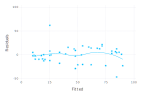

In [7]:
# Residual x fitted values (linearity + heteroscedasticity)
Gadfly.plot(x=fitted(mod), y=residuals(mod), 
    Geom.point, Geom.smooth, Guide.xlabel("Fitted"), 
    Guide.ylabel("Residuals"))

## Diagnostics

### Non-linearity

Let's `cook` a non-linear relation:

$$ Y = 2 + 3 X - 2 X^2 + \varepsilon $$

In [8]:
## Cooking
Random.seed!(4321)
cooked_data = DataFrame(x = randn(100))
cooked_data.y = 2 .+ 3 .* cooked_data.x .- 2 .* (cooked_data.x.^2) .+ randn(100)

## Fitting (wrong)
mod2 = lm(@formula(y ~ x), cooked_data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

y ~ 1 + x

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  0.289405    0.23487    1.23    0.2208  -0.176687   0.755496
x            4.07725     0.248684  16.40    <1e-29   3.58374    4.57075
────────────────────────────────────────────────────────────────────────

## Diagnostics

### Non-linearity

The smoothing trend line (the `lowess`) show a discernible trend.

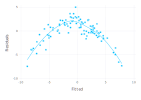

In [9]:
# Residual x fitted values (linearity + heteroscedasticity)
Gadfly.plot(x=fitted(mod2), y=residuals(mod2), 
    Geom.point, Geom.smooth, Guide.xlabel("Fitted"), 
    Guide.ylabel("Residuals"))

## Diagnostics

### Non-linearity

Let us fit the *right* model now:

In [10]:
mod3 = lm(@formula(y ~ x + x^2), cooked_data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

y ~ 1 + x + :(x ^ 2)

Coefficients:
─────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)   1.95788    0.14157    13.83    <1e-23    1.6769     2.23885
x             3.04486    0.128838   23.63    <1e-41    2.78916    3.30057
x ^ 2        -1.99214    0.106467  -18.71    <1e-33   -2.20345   -1.78083
─────────────────────────────────────────────────────────────────────────

## Diagnostics

### Non-linearity

And the residuals versus fitted values look better when fitting the correctly specified model:

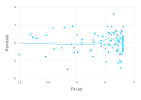

In [11]:
# Residual x fitted values (linearity + heteroscedasticity)
Gadfly.plot(x=fitted(mod3), y=residuals(mod3), 
    Geom.point, Geom.smooth, Guide.xlabel("Fitted"), 
    Guide.ylabel("Residuals"))

## Diagnostics

### Non-linearity

There exist a test called [Ramsey RESET test](https://en.wikipedia.org/wiki/Ramsey_RESET_test).

I strongly suggest you not to use these, since it usually does not identify better relationships than polynomial, while non-linearity can be something extremely complex.

We will learn how to deal with this in a few lectures.

## Diagnostics

### Heteroscedasticity

It is fancy wording to say that the variance in error is not constant.

It usually means that you are better at fitting some range of the predictors than others.

![reg](https://github.com/umbertomig/POLI175julia/blob/c9b0555e3e97778495bee72746aee43ddf3226d7/img/fig7.png?raw=true)

**Plot:** Fitted Values x Residuals

- Bad (left-hand side): A funnel-shaped figure tells you that you may have heteroscedasticity. It invalidates simple standard errors assumptions.

- Good (right-hand side): You should find no patterns.

## Diagnostics

### Heteroscedasticity

For the `prestige` x `income` relationship:

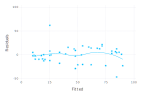

In [12]:
# Residual x fitted values (linearity + heteroscedasticity)
Gadfly.plot(x=fitted(mod), y=residuals(mod), 
    Geom.point, Geom.smooth, Guide.xlabel("Fitted"), 
    Guide.ylabel("Residuals"))

## Diagnostics

### Heteroskedasticity

Let us `cook` a heteroskedastic model:

$$ Y = 2 + 3 X + \tilde{\varepsilon} $$

Where $\text{Cov}[\tilde{\varepsilon}] \ \neq \ \sigma^2I$.

In this particular case, let us make the variance of the residuals to look like a football:

In [13]:
## Cooking (Het-error term)
Random.seed!(4321)
cooked_data = DataFrame(x = randn(100))
cooked_data.y = 2 .+ 3 .* cooked_data.x .+ (maximum(cooked_data.x .^ 2 .+ 1) .- ((cooked_data.x).^2)) .* randn(100);

In [14]:
## Fitting
mod4 = lm(@formula(y ~ x), cooked_data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

y ~ 1 + x

Coefficients:
──────────────────────────────────────────────────────────────────────
               Coef.  Std. Error     t  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────
(Intercept)  1.81334    0.586455  3.09    0.0026   0.649544    2.97715
x            3.0878     0.620947  4.97    <1e-05   1.85555     4.32005
──────────────────────────────────────────────────────────────────────

## Diagnostics

### Heteroscedasticity

For the cooked data:

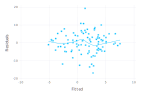

In [15]:
# Residual x fitted values (linearity + heteroscedasticity)
Gadfly.plot(x=fitted(mod4), y=residuals(mod4), 
    Geom.point, Geom.smooth, Guide.xlabel("Fitted"), 
    Guide.ylabel("Residuals"))

## Diagnostics

### Heteroscedasticity

Our standard errors are wrong. So are our:

1. Confidence Intervals
1. P-values
1. T-stats

In these cases, we need **robust standard errors**:

In [16]:
# Standard Errors for the heteroskedastic model
CovarianceMatrices.stderror(mod4)

2-element Vector{Float64}:
 0.5864548392542326
 0.6209471511463223

In [17]:
# Corrected Standard Errors for the heteroskedastic model
# Note: several types of corrections...
CovarianceMatrices.stderror(CovarianceMatrices.HC1(), mod4)

2-element Vector{Float64}:
 0.584994939976273
 0.43143233397505226

### Outliers

- Outliers are values very far away from most values predicted by the model.

- Sometimes, it is correct, but frequently it may tell you that you made a mistake in collecting the data!

![reg](https://github.com/umbertomig/POLI175julia/blob/c9b0555e3e97778495bee72746aee43ddf3226d7/img/fig8.png?raw=true)

**Plot**: Fitted x Studentized residuals (right-hand side plot)

- Best: You should find no extreme values in the plot.

- Bad: An extreme value can affect your RSE, $R^2$, and mess up with p-values.

## Diagnostics

### Outliers

A few important measurements (all vectors, computed for each data point):

[**Studentized residual**](https://en.wikipedia.org/wiki/Studentized_residual): Residual weighted by the leverage of the point. Studentized because it follows the [Student's t distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution).

[**Leverage**](https://en.wikipedia.org/wiki/Leverage_(statistics)): It represents how far away a given *target* value is compared to other *target* values $\bigg(\dfrac{\partial \hat{y}_i}{\partial y_i}\bigg)$.

[**Cook's Distance**](https://en.wikipedia.org/wiki/Cook%27s_distance): It measures how much the regression model changes when we remove a given observation.

In [18]:
#= We need to compute the studentized residual
   (https://en.wikipedia.org/wiki/Studentized_residual)
   I wrote this function to facilitate the work
=#
function lm_measures(lmod)
    X = modelmatrix(lmod)
    RSS = sum((residuals(lmod)).^2)
    sigma_hat = sqrt(RSS/dof_residual(lmod))
    leverage = diag(X * inv(transpose(X) * X) * transpose(X))
    studentized_resid = residuals(lmod) ./ (sigma_hat .* sqrt.(1 .- leverage))
    return leverage, studentized_resid, cooksdistance(lmod)
end

lm_measures (generic function with 1 method)

## Diagnostics

### Outliers

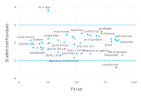

In [19]:
Gadfly.plot(
    x=fitted(mod), y=lm_measures(mod)[2], 
    Geom.point, label = dat.profession, 
    Guide.xlabel("Fitted"),
    Guide.ylabel("Studentized Residuals"), 
    Geom.label,
    yintercept = [-2.0, 2.0], 
    Geom.hline()
)

## Diagnostics

### Outliers

In [20]:
show(dat, allrows = true, allcols = true)

45×5 DataFrame
 Row │ type     income  education  prestige  profession         
     │ String7  Int64   Int64      Int64     String31           
─────┼──────────────────────────────────────────────────────────
   1 │ prof         62         86        82  accountant
   2 │ prof         72         76        83  pilot
   3 │ prof         75         92        90  architect
   4 │ prof         55         90        76  author
   5 │ prof         64         86        90  chemist
   6 │ prof         21         84        87  minister
   7 │ prof         64         93        93  professor
   8 │ prof         80        100        90  dentist
   9 │ wc           67         87        52  reporter
  10 │ prof         72         86        88  engineer
  11 │ prof         42         74        57  undertaker
  12 │ prof         76         98        89  lawyer
  13 │ prof         76         97        97  physician
  14 │ prof         41         84        59  welfare.worker
  15 │ prof         48        

## Diagnostics

### Outliers

In [21]:
mod2 = lm(@formula(prestige ~ income), 
    dat[(dat.profession .!= "minister"), :])
mod3 = lm(@formula(prestige ~ income), 
    dat[(dat.profession .!= "conductor"), :])
mod4 = lm(@formula(prestige ~ income), 
    dat[(dat.profession .!= "minister") .& (dat.profession .!= "conductor"), :])
regtable(mod, mod2, mod3, mod4)


-------------------------------------------------------
                               prestige                
              -----------------------------------------
                   (1)        (2)        (3)        (4)
-------------------------------------------------------
(Intercept)      2.457     -1.113      0.852     -2.744
               (5.190)    (4.454)    (4.790)    (3.901)
income        1.080***   1.132***   1.145***   1.197***
               (0.107)    (0.091)    (0.101)    (0.081)
-------------------------------------------------------
Estimator          OLS        OLS        OLS        OLS
-------------------------------------------------------
N                   45         44         44         43
R2               0.702      0.785      0.755      0.841
-------------------------------------------------------




## Diagnostics

### High Leverage

Having a very unusual value, that could potentially tilt the regression line towards it

***If high leverage and outlier, bad combination!***

![reg](https://github.com/umbertomig/POLI175julia/blob/c9b0555e3e97778495bee72746aee43ddf3226d7/img/fig9.png?raw=true)

**Plot**: Leverage x Studentizided residuals

- Best: You should find no extreme values in the plot.

- Bad: An extreme value can affect your fit.

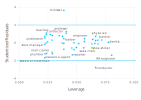

In [22]:
Gadfly.plot(
    x=lm_measures(mod)[1], y=lm_measures(mod)[2], 
    Geom.point, label = dat.profession, 
    Guide.xlabel("Leverage"),
    Guide.ylabel("Studentized Residuals"), 
    Geom.label,
    yintercept = [-2.0, 2.0], 
    Geom.hline()
)

## Diagnostics

### Cook's Distance

Measures whether removing a given observation tilts the regression coefficients.

**Plot**: Cook's Distance

- Best: You should find no values in the farther diagonal

- Bad: Extreme value in the farther diagonal represents data that is highly influential (high leverage) and high changes in coefficients (high Cook's D)

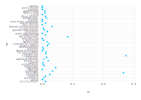

In [23]:
Gadfly.plot(
    y = dat.profession, x = lm_measures(mod)[3], 
    Geom.point
)

## Diagnostics

When we run multiple linear regression, we add *multicollinearity* to the diagnostics we have seen so far.

### Multicollinearity

Multicollinearity is when your predictors are highly correlated. In extreme cases, it messes up with the standard errors in our model (problems with inverse matrix).

1×5 DataFrame
 Row │ type     income  education  prestige  profession 
     │ String7  Int64   Int64      Int64     String31   
─────┼──────────────────────────────────────────────────
   1 │ prof         62         86        82  accountant


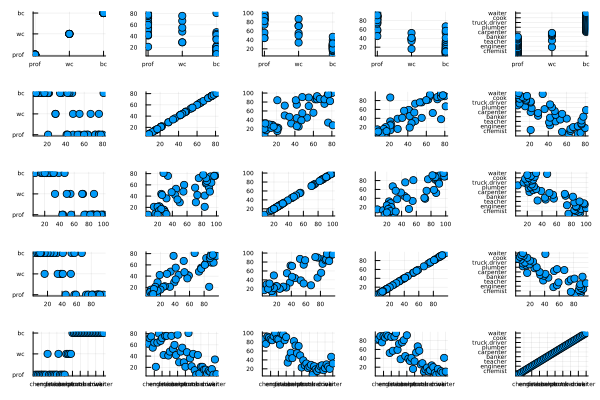

In [24]:
## Pairplot to check
println(first(dat, 1))
pairplot(dat)

## Diagnostics

### Multicollinearity

One measure of multicollinearity is the [*Variance Inflation Factor*](https://en.wikipedia.org/wiki/Variance_inflation_factor).

How much the multicollinearity is messing up with the estimates.
    
To compute, it is fairly easy. As a rule-of-thumb, we would like to see values lower than 5.

***It is rarely a problem, though... Especially with large datasets.***

In [25]:
modfull = lm(@formula(prestige ~ income + education + type), dat)
println(modfull)
MixedModelsExtras.vif(modfull)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

prestige ~ 1 + income + education + type

Coefficients:
───────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)   -0.185028   3.71377    -0.05    0.9605   -7.69084    7.32078
income         0.597546   0.0893553   6.69    <1e-07    0.416953   0.77814
education      0.345319   0.113609    3.04    0.0042    0.115707   0.574932
type: prof    16.6575     6.99301     2.38    0.0221    2.52412   30.7909
type: wc     -14.6611     6.10877    -2.40    0.0211  -27.0074    -2.31484
───────────────────────────────────────────────────────────────────────────


4-element Vector{Float64}:
 2.2091779795013604
 5.297583712426571
 5.562395007894013
 2.0437211074918307

## Diagnostics

Rules to diagnostics:

1. Always assume heteroskedasticity (use robust standard errors)
1. Check for outliers
1. Drop a few observations and rerun the regression. Do that with most (all) observations.
1. Graph your residual.
1. If you have extreme values, make sure your results remain valid after dropping them.

In a nutshell, pay attention to what you are doing!

# Questions?

# See you next class
